In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word

import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import TransformerMixin
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import metrics

In [13]:
import os
import sys

os.environ['SPARK_HOME'] = "C:\Users\Pedro\Downloads\spark-2.0.2-bin-hadoop2.7\spark-2.0.2-bin-hadoop2.7"


sys.path.append("C:\Users\Pedro\Downloads\spark-2.0.2-bin-hadoop2.7\spark-2.0.2-bin-hadoop2.7\python")
sys.path.append("C:\Users\Pedro\Downloads\spark-2.0.2-bin-hadoop2.7\spark-2.0.2-bin-hadoop2.7\python\lib\py4j-0.8.2.1-src.zip")

from spark_sklearn import GridSearchCV

In [16]:
movies = pd.read_pickle('movies.pkl')

#Replace missing values with actual Python NaN.
movies = movies.replace('N/A', np.NaN)
movies = movies.replace('NA', np.NaN)
movies = movies.replace('NULL', np.NaN)

#Set the imdbRating column as float instead of strings
movies.imdbRating = movies.imdbRating.astype(float)


In [17]:
#Makes a new Data Frame without movies with script missing.
movie_scripts = movies[(movies.script.notnull())].copy()
movie_scripts.reset_index(inplace = True)
del movie_scripts['index']

In [18]:
def sentiment(script, pages = 100, ma = 5):
    #Creates a moving average of the sentiment polarity of the script pages (or %)
    try:
        sentiment = []
        for i in range(pages+1):
            sentiment.append(TextBlob(script[i*len(script)/pages:(i+1)*len(script)/pages]).sentiment.polarity)
        MA = []
        for i in range(len(sentiment)-ma):
            MA.append(np.mean(sentiment[i:i+ma]))
        return MA
    except:
        return [0]
movie_scripts['sentiment'] = movies.script.apply(lambda x: sentiment(x))


In [19]:
movie_scripts['sentiment_avg'] = movie_scripts.sentiment.apply(lambda x: np.mean(x))
movie_scripts['sentiment_stdev'] = movie_scripts.sentiment.apply(lambda x: np.std(x))

In [20]:
#Remove rows where scripts were empty.
movie_scripts = movie_scripts[movie_scripts.sentiment_stdev != 0].copy()
del movie_scripts['level_0']
del movie_scripts['index']


KeyError: 'level_0'

In [21]:
import ast
#Select only the movies that were found with the IMDB API
movie_scripts = movie_scripts[movie_scripts.IMDB_info.apply(lambda x: ast.literal_eval(x['Response']))]


In [22]:
def awards(award):
    try:
        if 'Oscar' in award:
            return 1
        else:
            return 0
    except:
        return 0
movie_scripts.Awards = movie_scripts.Awards.apply(lambda x: awards(x)) 


C:\Anaconda2\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [24]:
movie_scores = movie_scripts[['title','script','Actors','Awards','Director', 'Genre','Runtime', 'Writer','imdbRating', 'sentiment',  'sentiment_avg','sentiment_stdev']].copy()
movie_scores = movie_scores.dropna()
len(movie_scores)
movie_scores.reset_index(inplace = True, drop = True)
movie_scores.head()

,title,script,Actors,Awards,Director,Genre,Runtime,Writer,imdbRating,sentiment,sentiment_avg,sentiment_stdev
0,10 Things I Hate About You,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",0,Gil Junger,"Comedy, Drama, Romance",97 min,"Karen McCullah, Kirsten Smith",7.2,"[0.11383952936, 0.105862606283, 0.081115874257...",0.050608,0.060887
1,12 and Holding,\n \n \n \n ...,"Conor Donovan, Jesse Camacho, Zoe Weizenbaum, ...",0,Michael Cuesta,Drama,94 min,Anthony Cipriano,7.6,"[0.0166268533054, -0.00886338353005, -0.051273...",0.012207,0.075825
2,12 Years a Slave,\n\r\n\r\n\r\n 12 ...,"Chiwetel Ejiofor, Dwight Henry, Dickie Gravois...",1,Steve McQueen,"Biography, Drama, History",134 min,"John Ridley (screenplay), Solomon Northup (bas...",8.1,"[0.144452514765, 0.152337532525, 0.14795544635...",0.049629,0.064201
3,127 Hours,\n\r\n\r\n \r\n ...,"James Franco, Kate Mara, Amber Tamblyn, Sean Bott",1,Danny Boyle,"Adventure, Biography, Drama",94 min,"Danny Boyle (screenplay), Simon Beaufoy (scree...",7.6,"[-0.00192164832522, -0.00922014348086, -0.0075...",0.052450,0.061374
4,1492: Conquest of Paradise,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Gérard Depardieu, Armand Assante, Sigourney We...",0,Ridley Scott,"Adventure, Biography, Drama",154 min,Rose Bosch (scenario),6.5,"[0.133802253193, 0.121926184817, 0.08588619306...",0.040886,0.068049


In [35]:
class SentimentMetrics(TransformerMixin):
    def changes (self, sentiments):
        N_changes = 0
        for i in range(len(sentiments)-1):
            if sentiments[i]*sentiments[i+1] < 0:
                N_changes+=1
        return N_changes     
    
    def sentiment(self, script, pages = 100, ma = 5):
        #Creates a moving average of the sentiment polarity of the script pages (or %)
        sentiment = []
        for i in range(pages+1-ma):
            sentiment.append(TextBlob(script[i*len(script)/pages:(i+ma)*len(script)/pages]).sentiment.polarity)
        return sentiment    
        
    def transform(self, X, **transform_params):  
        S = X.apply(lambda x: SentimentMetrics.sentiment(self, x))
        sentiment_dic = {
       'Range': S.apply(lambda x: max(x) - min(x)),
       #'Sentiment_avg': S.apply(lambda x: x.mean()),
       #'Sentiment_std': S.apply(lambda x: x.std()),
       'Max_sentiment': S.apply(lambda x: max(x)),
       'Max_sentiment_loc': S.apply(lambda x: x.index(max(x))),
       'Min_sentiment': S.apply(lambda x: min(x)),
       'Min_sentiment_loc': S.apply(lambda x: x.index(min(x))),
       'Max_pos_change': S.apply(lambda x: pd.Series(x).diff(1).max()),
       'Max_pos_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).max())),
       'Max_neg_change': S.apply(lambda x: pd.Series(x).diff(1).min()),
       'Max_neg_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).min())),
       'Begin_sentiment': S.apply(lambda x: x[0]),
       'End_sentiment': S.apply(lambda x: x[-1]),
       'Total_change': S.apply(lambda x: x[-1] - x[0]),
       'plot_twist_index': S.apply(lambda x: (max(x[-10:]) - min(x[-10:]))/(max(x[:-10]) - min(x[:-10]) + 0.01)),
       'pol_changes': S.apply(lambda x: SentimentMetrics.changes(self, x))
        }
            
        return sp.sparse.csr_matrix(pd.DataFrame(sentiment_dic).astype(float))
    
        
    
    def fit(self, X, y=None, **fit_params):
        return self      

class NamedEntities(TransformerMixin):        
    def number_entities(self, text):
        upper = [i for i in TextBlob(text).words if (i.isupper() and i.lower() not in stopwords.words('english'))]
        tagged = pos_tag(upper)
        return len(set([word for word,pos in tagged if pos == 'NNP']))
    
    def transform (self, X):
        return pd.DataFrame(X.apply(lambda x: NamedEntities.number_entities(self,x)))
    
    def fit(self, X, y=None, **fit_params):
        return self      

In [36]:
class SelectColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def transform(self, X, **transform_params):
        return X[self.column]
    
    def fit(self, X, y=None, **fit_params):
        return self      

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
def sentence_tokenize(text):
    words = TextBlob(text.replace(',', '.')).sentences
    return [word for word in words]
   

In [47]:
from sklearn import decomposition

class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self
    

dense = DenseTransformer()
pca = decomposition.PCA()
script_pipeline = Pipeline([('selectScript', SelectColumn('script')),
                            ('feature', FeatureUnion([('sentiment', SentimentMetrics()),
                                                      ('tfidf', TfidfVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=[1,3], min_df=5, max_df = 500)),
                                                      ('named_entities', NamedEntities())]))])

actors_pipeline = Pipeline([('SelectActors', SelectColumn('Actors')),
                            ('count', CountVectorizer(analyzer = lambda x: sentence_tokenize(x)))])

pip = Pipeline([('feature_main', FeatureUnion([('script', script_pipeline),
                                                        ('actors', actors_pipeline)])),
                                                        ('dense', dense)])
X_r = pca.fit_transform(pip.fit_transform(movie_scores))

In [59]:
a = pip.fit_transform(movie_scores)

In [60]:
a.shape

(764L, 47049L)

In [83]:
b = pd.DataFrame(a)
b.head()

,0,1,2,3,4,5,6,7,8,9,...,47039,47040,47041,47042,47043,47044,47045,47046,47047,47048
0,0.114335,-0.152499,-0.090298,37.0,0.111799,29.0,0.188085,34.0,-0.166735,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.014466,-0.071560,-0.097999,49.0,0.083092,44.0,0.249427,44.0,-0.095618,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.149347,-0.024999,-0.062989,51.0,0.045550,46.0,0.181162,5.0,-0.049386,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.004935,0.173417,-0.082510,75.0,0.070541,95.0,0.173417,95.0,-0.133540,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.132225,0.079125,-0.097484,89.0,0.088118,38.0,0.192288,42.0,-0.099072,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
pca = decomposition.PCA()
c = pca.fit_transform(b)

explained variance ratio: [ 0.96791089  0.01228404  0.00846586  0.00577807  0.0051554 ]


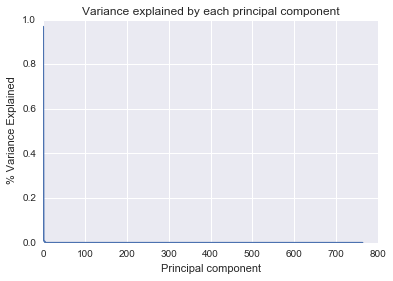

In [80]:
print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_[:5]))

plt.plot(pca.explained_variance_ratio_)
plt.title('Variance explained by each principal component')
plt.ylabel(' % Variance Explained')
plt.xlabel('Principal component')


In [30]:
script_pipeline = Pipeline([('selectScript', SelectColumn('script')),
                            ('feature', FeatureUnion([('sentiment', SentimentMetrics()),
                                                      ('tfidf', TfidfVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=[1,3], min_df=5, max_df = 500)),
                                                      ('named_entities', NamedEntities())]))])

actors_pipeline = Pipeline([('SelectActors', SelectColumn('Actors')),
                            ('count', CountVectorizer(analyzer = lambda x: sentence_tokenize(x)))])

main_pipeline = Pipeline([('feature_main', FeatureUnion([('script', script_pipeline),
                                                        ('actors', actors_pipeline)])),
                         ('forest', RandomForestRegressor(n_estimators=10))
                          ])

In [33]:
score =  cross_val_score(main_pipeline, movie_scores, movie_scores.imdbRating, cv=4, scoring='mean_absolute_error')
#TfidfVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=[1,3], min_df=3)

KeyboardInterrupt: 